# Eleven - Hackathon

## 0] Prérequis



#### 1. Useful links

* Pytorch documentation https://pytorch.org/docs/stable/index.html
* Basic Pytorch tutorial https://pytorch.org/tutorials/beginner/basics/intro.html


#### 2. GPU and Colab

You have an option to **use GPU by setting the flag to True below**. It is not necessary to use GPU for this assignment. Note that if your computer does not have CUDA enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment.

You need to manually switch to a GPU device. You can do this by clicking `Exécution -> Modifier le type d'exécution` and selecting `GPU` under `Accélérateur matèriel`. Note that you have to rerun the cells from the top since the kernel gets restarted upon switching runtimes.

In [1]:
import torch

USE_GPU = False
dtype = torch.float32 # we will be using float throughout this tutorial
device = torch.device('cuda') if (USE_GPU and torch.cuda.is_available()) else torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100
print('using device:', device)

using device: cpu


# Table of Contents



I. Visualisation and preparation

# Part I. Visualisation & Preparation

In this section, we will load and preprocess the data used.
The following code allows you first to visualize the data:

#I.1) Visualisation


Following code allows you to mount your drive in the Colab Virtual Machine in order to get access to the data (skipped if run locally)

In [2]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  FOLDERNAME = 'ELEVEN_HACKATHON'
  %cd /content/gdrive/My\ Drive/$FOLDERNAME
except ImportError:
  pass

Mounted at /content/gdrive
/content/gdrive/My Drive/ELEVEN_HACKATHON


In [3]:
# Some imports
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pathlib
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import numpy as np
import pandas as pd
import numpy as np
import datetime
import random
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from xgboost import XGBClassifier



On peut commencer à analyser les données brutes en notre possession:


In [72]:
weather_data = pd.read_csv("weather_data.csv")
waiting_times_train = pd.read_csv("waiting_times_train.csv")

waiting_times_val = pd.read_csv("waiting_times_X_test_val.csv")

print(f'shape de weather_data ={ weather_data.shape}')
print(f'shape de waiting_times_train ={ waiting_times_train.shape}')
print(f'shape de waiting_times_val ={ waiting_times_val.shape}')
waiting_times_train.head(), weather_data.head()

shape de weather_data =(135933, 10)
shape de waiting_times_train =(37018, 9)
shape de waiting_times_val =(2444, 8)


(              DATETIME ENTITY_DESCRIPTION_SHORT  ADJUST_CAPACITY  DOWNTIME  \
 0  2022-02-05 11:45:00               Water Ride           247.00         0   
 1  2019-02-24 10:45:00               Water Ride           247.00         0   
 2  2021-07-17 15:45:00              Pirate Ship           280.50         0   
 3  2022-04-03 19:45:00              Pirate Ship           230.35         0   
 4  2021-10-20 10:30:00              Pirate Ship           153.00         0   
 
    CURRENT_WAIT_TIME  TIME_TO_PARADE_1  TIME_TO_PARADE_2  TIME_TO_NIGHT_SHOW  \
 0                 20               NaN               NaN                 NaN   
 1                 30             375.0               NaN               495.0   
 2                 35               NaN               NaN                 NaN   
 3                 15            -135.0               NaN               195.0   
 4                 15               NaN               NaN                 NaN   
 
    WAIT_TIME_IN_2H  
 0            



Ce premier travail permet de déterminer la taille de la database et le nombre total de features. Notre premier travail est de conserver les features pertinentes.

#Commentaire

On suppose que les conditions climatiques auront un rôle à jouer dans la fréquentation du parc d'attraction. Il faut donc inclure weather dans les données d'entraînement:

Notre label est le temps d'attente dans 2 heures.
On en profite pour inclure les temps à prédire dans un dataframe y_train

In [73]:
train_data = pd.merge(waiting_times_train, weather_data, on='DATETIME', how='inner')
valid_data = pd.merge(waiting_times_val, weather_data, on='DATETIME', how='inner')

y_train = train_data['WAIT_TIME_IN_2H'].copy()
train_data.drop(columns=['WAIT_TIME_IN_2H'])


print(f'shape de train_data ={ train_data.shape}')
train_data.head()

print(f'shape de y_train ={ y_train.shape}')
y_train.head()

shape de train_data =(37018, 18)
shape de y_train =(37018,)


0    30.0
1    50.0
2    15.0
3    25.0
4    25.0
Name: WAIT_TIME_IN_2H, dtype: float64

#I.2) Préprocessing

#Données pertinente

En ce qui concerne les données temporelles. Ce qui compte est d'abord le mois et la date. Puisqu'on ne connait pas le pays du parc d'attraction, on ne peut pas connaitre les dates de vacances. On peut néanmoins distinguer les différents jours de la semaine. On pense avoir plus de monde les week-ends.
Il n'y aura pas la même fréquentation sur les trois attractions. Par exemple, il est probable de ne pas avoir beaucoup de fréquentation à "water ride" en fin de journée à cause du froid ni l'hiver de manière générale.

#Quid des Nan

La première difficulté de ce Hackathon est de gérer et d'interpréter les valeurs manquantes dans notre base de données. Nous comptons environ 80 pourcents de données manquantes dans time_to_parade2 et un nombre non négligeable dans time_to_parade1 et time_to_night_show. Nous pensons que la parade n'a tous simplement pas lieu tous les jours en raison d'une faible fréquentation ou de condition météorologique. Nous n'avons pas étayé cette hypothèse par des tests sur la base de données précis mais seulement par des observations à l'oeil ( à faire ).


#Stratégie choisie

Ce notebook se concentre sur une approche de classification. En effet, nous cherchons à déterminer le temps d'attente à 5 minutes près. Nous vérifions sans peine que celui-ci est très souvent compris entre 5 et 45 minutes. Ainsi nous pouvons créer 90/5=18 catégories correspondant à 18 intervalles de temps de 5 minutes.

Dans ce premier jet, on n'utilise pas weather ni les minutes ni le temps avant les parades pour le temps, on aimerait avoir quelque chose de continu. La combinaison des heures et des minutes doivent être proche. On pourait écrire le temps comme 60*hour + minutes, ou essayer de jouer avec des cosinus et des sinus pour avoir quelque chose de périodique. Pareil pour les jours et les mois, Décembre est proche de janvier.


In [74]:
# Convert 'DATETIME' column to datetime type
train_data['DATETIME'] = pd.to_datetime(train_data['DATETIME'])
valid_data['DATETIME'] = pd.to_datetime(valid_data['DATETIME'])

import pandas as pd

def is_day_of_work(day_of_week):
    return 1 if day_of_week < 5 else 0

def is_saturday(day_of_week):
    return 1 if day_of_week == 5 else 0

def is_sunday(day_of_week):
    return 1 if day_of_week == 6 else 0


def hour_in_range(hour, start, end):
    return 1 if start <= hour <= end else 0

def is_ride_type(description, ride_type):
    return 1 if description == ride_type else 0

def is_ride_type_dim_min(description):
  if description == 'Flying Coaster' : return 1
  elif description == 'Water Ride' : return 2
  else: return 3

# Specific functions for ride types can call is_ride_type with appropriate parameters
def is_flying_coaster(description):
    return is_ride_type(description, 'Flying Coaster')

def is_water_ride(description):
    return is_ride_type(description, 'Water Ride')

def is_pirate_ship(description):
    return is_ride_type(description, 'Pirate Ship')

def hour_in_range(dt, start_hour, end_hour):
    total_minutes = dt.hour * 60 + dt.minute  # Convertit l'heure et les minutes en minutes totales
    start_minutes = start_hour * 60
    end_minutes = end_hour * 60
    return 1 if start_minutes <= total_minutes < end_minutes else 0


# Applying the functions to create the appropriate columns
train_data['day_of_work'] = train_data['DATETIME'].dt.dayofweek.apply(is_day_of_work)
train_data['saturday'] = train_data['DATETIME'].dt.dayofweek.apply(is_saturday)
train_data['sunday'] = train_data['DATETIME'].dt.dayofweek.apply(is_sunday)

#train_data['is_ferie'] = train_data['DATETIME'].apply(is_ferie)

train_data['is_flying_coaster'] = train_data['ENTITY_DESCRIPTION_SHORT'].apply(is_flying_coaster)
train_data['is_water_ride'] = train_data['ENTITY_DESCRIPTION_SHORT'].apply(is_water_ride)
train_data['is_pirate_ship'] = train_data['ENTITY_DESCRIPTION_SHORT'].apply(is_pirate_ship)

train_data['hour_in_10_11'] = train_data['DATETIME'].apply(lambda dt: hour_in_range(dt, 10, 11))
train_data['hour_in_11_12'] = train_data['DATETIME'].apply(lambda dt: hour_in_range(dt, 11, 12))
train_data['hour_in_12_14'] = train_data['DATETIME'].apply(lambda dt: hour_in_range(dt, 12, 14))
train_data['hour_in_14_16'] = train_data['DATETIME'].apply(lambda dt: hour_in_range(dt, 14, 16))
train_data['hour_in_16_17'] = train_data['DATETIME'].apply(lambda dt: hour_in_range(dt, 16, 17))
train_data['hour_in_17_18'] = train_data['DATETIME'].apply(lambda dt: hour_in_range(dt, 17, 18))
train_data['hour_in_18_20'] = train_data['DATETIME'].apply(lambda dt: hour_in_range(dt, 18, 20))
train_data['hour_in_20_21'] = train_data['DATETIME'].apply(lambda dt: hour_in_range(dt, 20, 21))
train_data['hour_in_21_22'] = train_data['DATETIME'].apply(lambda dt: hour_in_range(dt, 21, 22))


#train_data['minute'] = train_data['DATETIME'].dt.minute
#train_data['hour'] = train_data['DATETIME'].dt.hour
train_data['month'] = train_data['DATETIME'].dt.month

#A FAIRE ARRONDIR L'HEURE AVEC LES MINUTES: EXEMPLE: 11H45 ---> 12H

#train_data['parade_show_impact'] = train_data.apply(apply_parade_or_show_impact, axis=1)



valid_data['day_of_work'] = valid_data['DATETIME'].dt.dayofweek.apply(is_day_of_work)
valid_data['saturday'] = valid_data['DATETIME'].dt.dayofweek.apply(is_saturday)
valid_data['sunday'] = valid_data['DATETIME'].dt.dayofweek.apply(is_sunday)


valid_data['is_flying_coaster'] = valid_data['ENTITY_DESCRIPTION_SHORT'].apply(is_flying_coaster)
valid_data['is_water_ride'] = valid_data['ENTITY_DESCRIPTION_SHORT'].apply(is_water_ride)
valid_data['is_pirate_ship'] = valid_data['ENTITY_DESCRIPTION_SHORT'].apply(is_pirate_ship)

valid_data['hour_in_10_11'] = valid_data['DATETIME'].apply(lambda dt: hour_in_range(dt, 10, 11))
valid_data['hour_in_11_12'] = valid_data['DATETIME'].apply(lambda dt: hour_in_range(dt, 11, 12))
valid_data['hour_in_12_14'] = valid_data['DATETIME'].apply(lambda dt: hour_in_range(dt, 12, 14))
valid_data['hour_in_14_16'] = valid_data['DATETIME'].apply(lambda dt: hour_in_range(dt, 14, 16))
valid_data['hour_in_16_17'] = valid_data['DATETIME'].apply(lambda dt: hour_in_range(dt, 16, 17))
valid_data['hour_in_17_18'] = valid_data['DATETIME'].apply(lambda dt: hour_in_range(dt, 17, 18))
valid_data['hour_in_18_20'] = valid_data['DATETIME'].apply(lambda dt: hour_in_range(dt, 18, 20))
valid_data['hour_in_20_21'] = valid_data['DATETIME'].apply(lambda dt: hour_in_range(dt, 20, 21))
valid_data['hour_in_21_22'] = valid_data['DATETIME'].apply(lambda dt: hour_in_range(dt, 21, 22))

#valid_data['minute'] = valid_data['DATETIME'].dt.minute
#valid_data['hour'] = valid_data['DATETIME'].dt.hour
valid_data['month'] = valid_data['DATETIME'].dt.month


# Extract year, month, day, hour, and minute from 'DATETIME' column
#train_data['year'] = train_data['DATETIME'].dt.year
#train_data['month'] = train_data['DATETIME'].dt.month
#train_data['day'] = train_data['DATETIME'].dt.day
#train_data['hour'] = train_data['DATETIME'].dt.hour
#train_data['minute'] = train_data['DATETIME'].dt.minute

#Delete the column datetime

# Display the first few rows of the dataframe to confirm the changes
print(f'shape de train_data ={ train_data.shape}')
train_data.head()



shape de train_data =(37018, 34)


,DATETIME,ENTITY_DESCRIPTION_SHORT,ADJUST_CAPACITY,DOWNTIME,CURRENT_WAIT_TIME,TIME_TO_PARADE_1,TIME_TO_PARADE_2,TIME_TO_NIGHT_SHOW,WAIT_TIME_IN_2H,temp,...,hour_in_10_11,hour_in_11_12,hour_in_12_14,hour_in_14_16,hour_in_16_17,hour_in_17_18,hour_in_18_20,hour_in_20_21,hour_in_21_22,month
0,2022-02-05 11:45:00,Water Ride,247.0,0,20,NaN,NaN,NaN,30.0,6.0175,...,0,1,0,0,0,0,0,0,0,2
1,2022-02-05 11:45:00,Flying Coaster,756.0,0,50,NaN,NaN,NaN,50.0,6.0175,...,0,1,0,0,0,0,0,0,0,2
2,2022-02-05 11:45:00,Pirate Ship,153.0,0,50,NaN,NaN,NaN,15.0,6.0175,...,0,1,0,0,0,0,0,0,0,2
3,2019-02-24 10:45:00,Water Ride,247.0,0,30,375.0,NaN,495.0,25.0,7.9200,...,1,0,0,0,0,0,0,0,0,2
4,2019-02-24 10:45:00,Flying Coaster,756.0,0,15,375.0,NaN,495.0,25.0,7.9200,...,1,0,0,0,0,0,0,0,0,2


<ipython-input-47-608a525f7948>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_data.corr()


<Axes: >

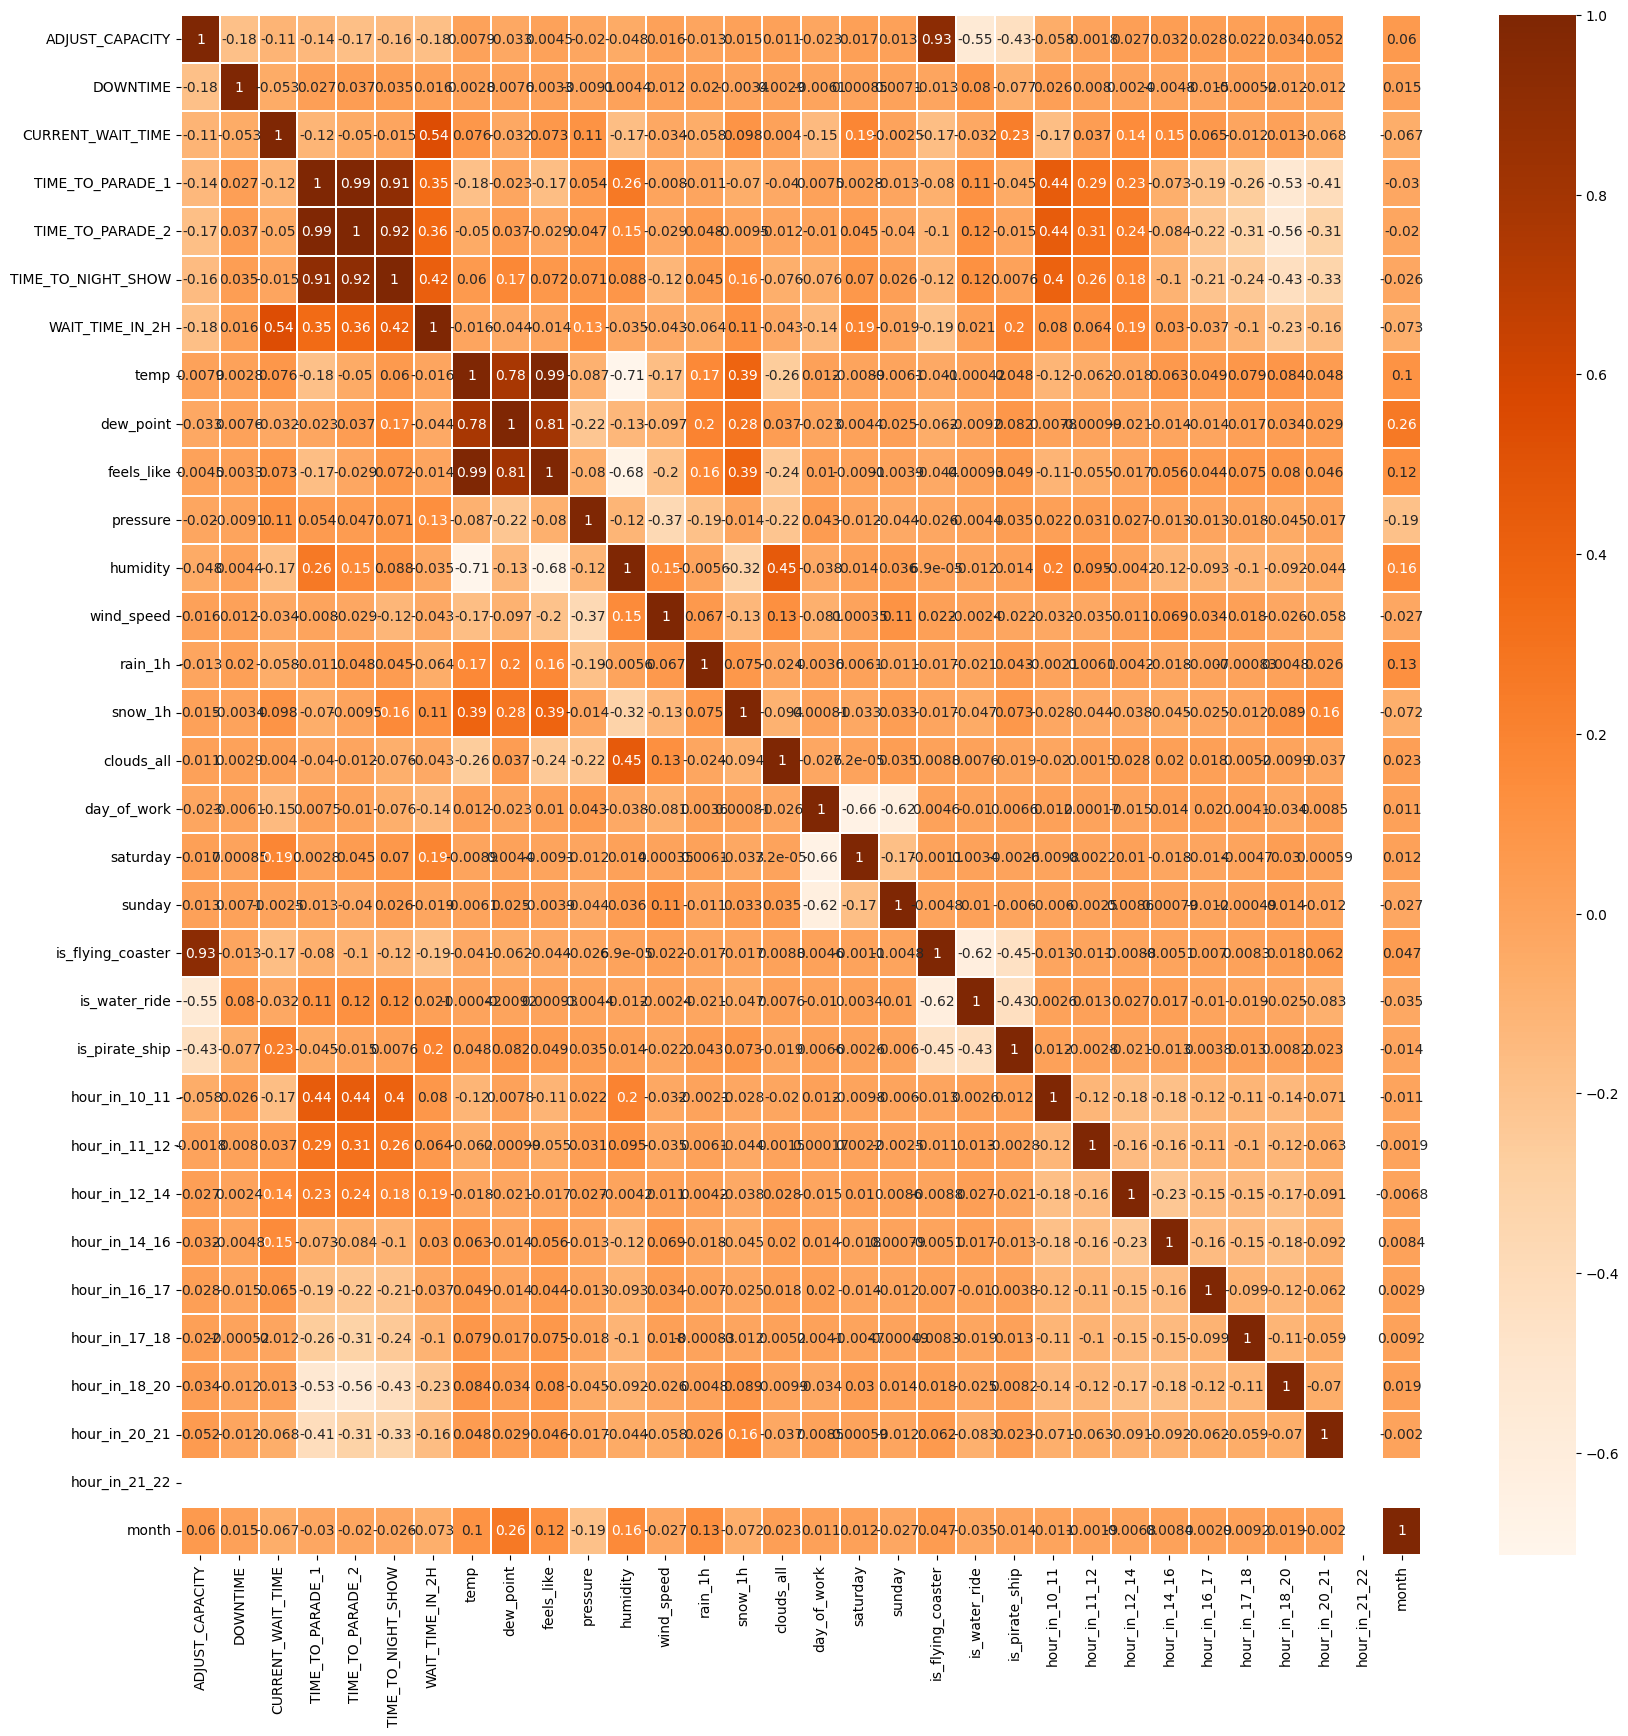

In [47]:
correlation_matrix = train_data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot= True, linewidth=0.1, cmap= 'Oranges')

On se rend compte que beaucoup de colonne sont fortement corrélées, on choisit d'abord de supprimer celles qui le sont trop comme température et témpérature ressenti.

remained features  Index(['CURRENT_WAIT_TIME', 'temp', 'rain_1h', 'snow_1h', 'day_of_work',
       'saturday', 'sunday', 'is_flying_coaster', 'is_water_ride',
       'is_pirate_ship', 'hour_in_10_11', 'hour_in_11_12', 'hour_in_12_14',
       'hour_in_14_16', 'hour_in_16_17', 'hour_in_17_18', 'hour_in_18_20',
       'hour_in_20_21', 'hour_in_21_22', 'month'],
      dtype='object')


<Axes: >

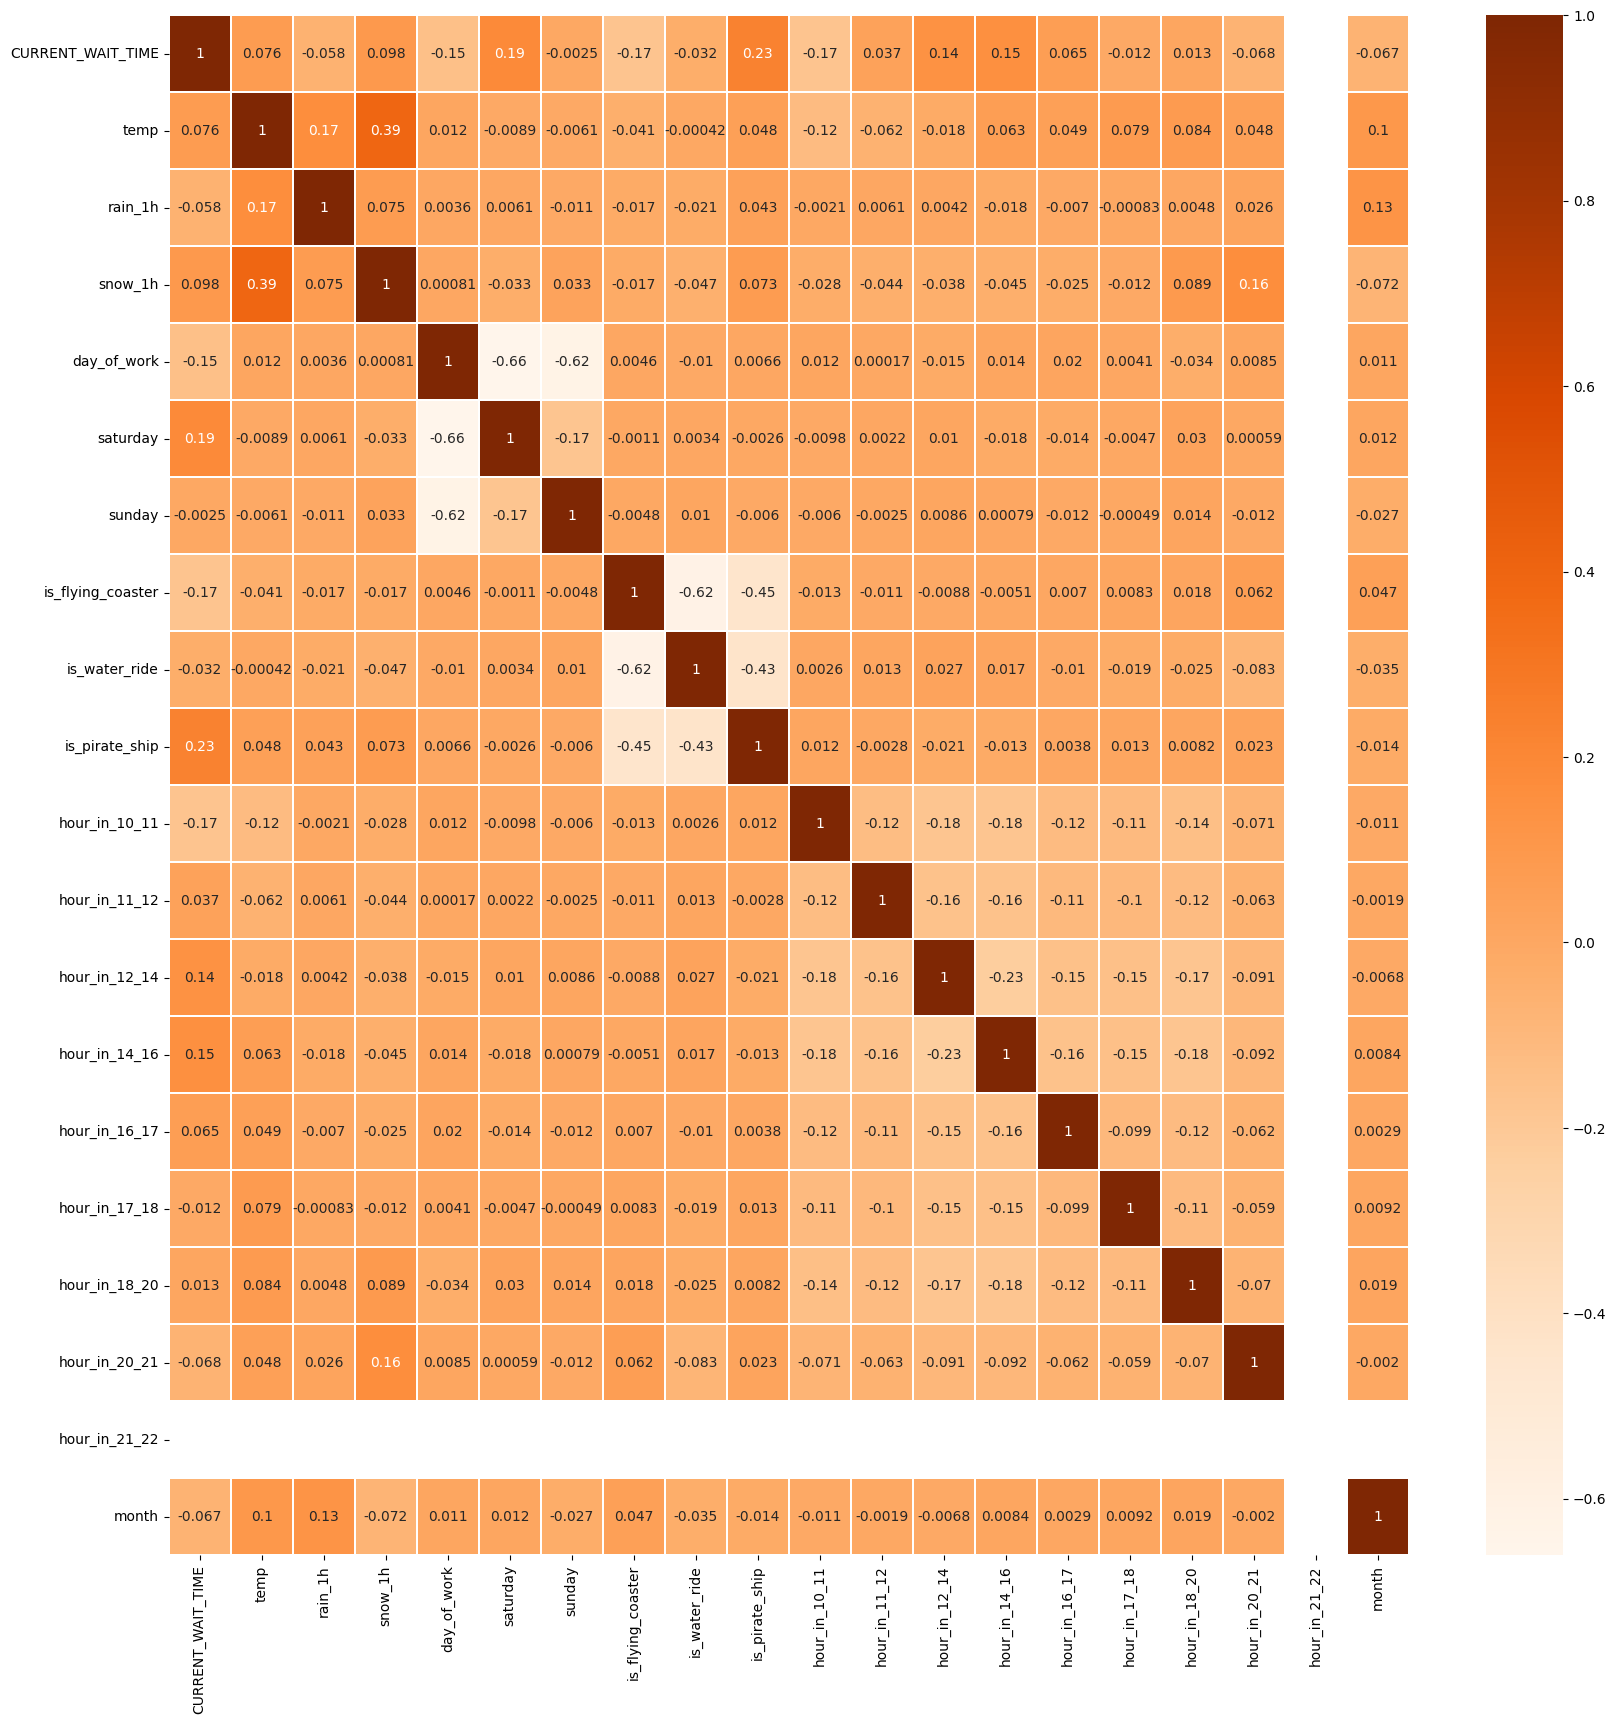

In [48]:
train_data = train_data.drop(columns=['DOWNTIME', 'ADJUST_CAPACITY', 'clouds_all', 'wind_speed', 'TIME_TO_PARADE_1', 'TIME_TO_PARADE_2', 'TIME_TO_NIGHT_SHOW', 'dew_point', 'feels_like', 'pressure', 'WAIT_TIME_IN_2H', 'humidity', 'DATETIME', 'ENTITY_DESCRIPTION_SHORT', ])
print("remained features ", train_data.columns)

valid_data = valid_data.drop(columns=['DOWNTIME', 'clouds_all', 'ADJUST_CAPACITY', 'wind_speed', 'TIME_TO_PARADE_1', 'TIME_TO_PARADE_2', 'TIME_TO_NIGHT_SHOW', 'dew_point', 'feels_like', 'pressure', 'humidity', 'DATETIME', 'ENTITY_DESCRIPTION_SHORT', ])

correlation_matrix = train_data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot= True, linewidth=0.1, cmap= 'Oranges')

In [13]:
print(y_train)


0        30.0
1        50.0
2        15.0
3        25.0
4        25.0
         ... 
37013    20.0
37014    20.0
37015     0.0
37016     5.0
37017    10.0
Name: WAIT_TIME_IN_2H, Length: 37018, dtype: float64


In [49]:
encoder = OneHotEncoder(sparse=False)
waiting_time_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))

encoded_labels = pd.DataFrame(waiting_time_encoded, columns=[f'interval_{int(cat)}' for cat in encoder.categories_[0]])
print(encoded_labels)

       interval_0  interval_5  interval_10  interval_15  interval_20  \
0             0.0         0.0          0.0          0.0          0.0   
1             0.0         0.0          0.0          0.0          0.0   
2             0.0         0.0          0.0          1.0          0.0   
3             0.0         0.0          0.0          0.0          0.0   
4             0.0         0.0          0.0          0.0          0.0   
...           ...         ...          ...          ...          ...   
37013         0.0         0.0          0.0          0.0          1.0   
37014         0.0         0.0          0.0          0.0          1.0   
37015         1.0         0.0          0.0          0.0          0.0   
37016         0.0         1.0          0.0          0.0          0.0   
37017         0.0         0.0          1.0          0.0          0.0   

       interval_25  interval_30  interval_35  interval_40  interval_45  ...  \
0              0.0          1.0          0.0          0.

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pour pouvoir utiliser le classifier, il faut vérifier qu'il n'y a pas de NaN dans les données. Il y en a pour rain et snow. On remplit par une nouvelle valeur 0 pour montrer l'absence de pluie ou l'absence de mesure. Cela a l'air cohérent avec la donnée. En effet plus il y a de pluie et plus la donnée est grande


In [50]:
train_data = train_data.fillna(0)
valid_data = valid_data.fillna(0)

#II]Modèle

On va déterminer la meilleure approche entre une régression logistique, xgboost ou random forest


II]1) Régression logistique

Pour opérer une régression logistique, nous utilisons deux couches linéaires auquel nous ajoutons un softmax. Enfin pour utiliser l'estimateur du maximum du vraisemblance, nous utilisons la loss cross.entropy (cf cours)

In [66]:
# Définition du modèle
class KClassLogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(KClassLogisticRegression, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        return out


input_size = train_data.shape[1]
num_classes = encoded_labels.shape[1]

print(input_size)
print(num_classes)

model = KClassLogisticRegression(input_size, num_classes)
criterion = nn.CrossEntropyLoss()

20
21


In [56]:
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_data)

valid_features_normalized = scaler.transform(valid_data)


train_features_tensor = torch.tensor(train_features_normalized, dtype=torch.float)
valid_features_tensor = torch.tensor(valid_features_normalized, dtype=torch.float)

labels_tensor = torch.tensor(encoded_labels.values, dtype=torch.float)

train_dataset = TensorDataset(train_features_tensor, labels_tensor)
valid_dataset = TensorDataset(valid_features_tensor)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size)


#Savoir faire

On prend un grand taux d'apprentissage au débuet on le divise lorsque le système semble converger


In [67]:
num_epochs=10
optimizer = optim.Adam(model.parameters(), lr=0.001)
#boucle d'entraînement
for epoch in range(num_epochs):
    model.train()  # Mode d'entraînement
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, input_size)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Époque [{epoch+1}/{num_epochs}], Étape [{i+1}/{len(train_loader)}], Perte: {loss.item():.4f}')

Époque [1/10], Étape [100/579], Perte: 2.1246
Époque [1/10], Étape [200/579], Perte: 2.0730
Époque [1/10], Étape [300/579], Perte: 2.1084
Époque [1/10], Étape [400/579], Perte: 2.0636
Époque [1/10], Étape [500/579], Perte: 1.8426
Époque [2/10], Étape [100/579], Perte: 1.9482
Époque [2/10], Étape [200/579], Perte: 2.0480
Époque [2/10], Étape [300/579], Perte: 1.7382
Époque [2/10], Étape [400/579], Perte: 1.8854
Époque [2/10], Étape [500/579], Perte: 1.8002
Époque [3/10], Étape [100/579], Perte: 1.8568
Époque [3/10], Étape [200/579], Perte: 1.7279
Époque [3/10], Étape [300/579], Perte: 1.9935
Époque [3/10], Étape [400/579], Perte: 1.9441
Époque [3/10], Étape [500/579], Perte: 1.7623
Époque [4/10], Étape [100/579], Perte: 2.0067
Époque [4/10], Étape [200/579], Perte: 1.9221
Époque [4/10], Étape [300/579], Perte: 1.6830
Époque [4/10], Étape [400/579], Perte: 1.9036
Époque [4/10], Étape [500/579], Perte: 1.6679
Époque [5/10], Étape [100/579], Perte: 1.9770
Époque [5/10], Étape [200/579], Pe

Il faut maintenant utiliser le modèle pour avoir des prédictions sur le validation_set:

In [68]:
def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for X_batch in data_loader:
            X_batch = X_batch[0]
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.tolist())
    return predictions

# Obtention des prédictions
valid_predictions_reseau = get_predictions(model, valid_loader)

print(valid_predictions_reseau)


[6, 8, 8, 9, 3, 1, 5, 7, 8, 5, 5, 8, 1, 6, 4, 3, 3, 4, 1, 3, 4, 5, 10, 3, 6, 10, 8, 5, 5, 4, 1, 1, 4, 6, 6, 6, 1, 5, 5, 6, 2, 1, 4, 1, 1, 3, 4, 9, 7, 1, 4, 4, 1, 1, 0, 4, 4, 2, 7, 1, 1, 3, 1, 9, 5, 5, 4, 3, 4, 5, 0, 5, 7, 5, 8, 1, 6, 6, 6, 4, 5, 5, 3, 8, 1, 6, 6, 1, 6, 2, 4, 4, 6, 8, 6, 7, 8, 4, 7, 7, 1, 4, 4, 5, 3, 6, 8, 4, 7, 8, 4, 1, 8, 7, 7, 5, 8, 7, 1, 4, 5, 7, 4, 4, 5, 8, 0, 1, 1, 4, 1, 6, 3, 3, 6, 6, 3, 1, 6, 5, 6, 1, 3, 1, 6, 10, 1, 3, 3, 6, 1, 1, 4, 6, 3, 3, 1, 6, 4, 7, 7, 1, 0, 6, 6, 2, 5, 4, 8, 6, 1, 3, 6, 8, 6, 9, 3, 4, 1, 6, 1, 1, 6, 5, 7, 7, 3, 6, 7, 8, 4, 9, 4, 1, 1, 8, 7, 8, 8, 2, 7, 7, 7, 6, 3, 8, 8, 1, 1, 7, 0, 5, 0, 7, 1, 6, 1, 3, 4, 4, 4, 1, 1, 4, 3, 9, 6, 6, 7, 7, 6, 4, 4, 5, 6, 1, 4, 6, 4, 6, 2, 1, 3, 1, 4, 7, 5, 5, 6, 9, 6, 9, 7, 3, 2, 1, 3, 5, 0, 3, 6, 10, 6, 7, 3, 1, 6, 8, 7, 7, 7, 8, 8, 7, 6, 7, 4, 7, 4, 1, 8, 7, 5, 1, 1, 1, 4, 6, 8, 9, 6, 6, 6, 5, 4, 5, 8, 5, 6, 1, 2, 8, 10, 6, 6, 7, 7, 4, 4, 9, 8, 7, 7, 10, 7, 6, 3, 6, 8, 6, 6, 6, 3, 4, 3, 10, 7, 5, 6, 1, 4,

#MISE SOUS LE BON FORMAT

In [69]:
export_df = pd.DataFrame()

# Copier les colonnes nécessaires de `waiting_times_val` dans `export_df`
export_df['DATETIME'] = waiting_times_val['DATETIME'].copy()
export_df['ENTITY_DESCRIPTION_SHORT'] = waiting_times_val['ENTITY_DESCRIPTION_SHORT'].copy()

# Ajouter les prédictions et la colonne 'KEY'
export_df['y_pred'] = valid_predictions_reseau
export_df['KEY'] = 'Validation'

# Chemin d'accès correct sous Windows, assurez-vous de remplacer VotreNomUtilisateur
path = r'pred_reseau2.csv'

# Enregistrement direct du DataFrame dans un fichier CSV
export_df.to_csv(path, index=False)

#Résultat

On a un score ignoble de 24 (RMSE) ce qui nous oblige à améliorer notre modèle. On peut penser qu'on a davantage d'intérêt à réduire la dimension du problème. A vu d'oeil, ce qui compte vraiment est la donnée 'current_wait_time'.
Avant d'ajouter un travail supplémentaire à nos features, on poursuit une approche de classification en réduisant la dimension.

#II)2) Essai avec Random Forest

In [80]:
weather_data = pd.read_csv("weather_data.csv")
waiting_times_train = pd.read_csv("waiting_times_train.csv")
waiting_times_val = pd.read_csv("waiting_times_X_test_val.csv")
train_data = pd.merge(waiting_times_train, weather_data, on='DATETIME', how='inner')
valid_data = pd.merge(waiting_times_val, weather_data, on='DATETIME', how='inner')
y_train = train_data['WAIT_TIME_IN_2H'].copy()

# Convert 'DATETIME' column to datetime type
train_data['DATETIME'] = pd.to_datetime(train_data['DATETIME'])
valid_data['DATETIME'] = pd.to_datetime(valid_data['DATETIME'])

train_data['ENTITY_TYPE'] = train_data['ENTITY_DESCRIPTION_SHORT'].apply(is_ride_type_dim_min)
valid_data['ENTITY_TYPE'] = valid_data['ENTITY_DESCRIPTION_SHORT'].apply(is_ride_type_dim_min)

train_data['hour'] = train_data['DATETIME'].dt.hour
valid_data['hour'] = valid_data['DATETIME'].dt.hour

train_data = train_data.drop(columns=['DOWNTIME', 'ADJUST_CAPACITY', 'clouds_all', 'wind_speed', 'TIME_TO_PARADE_1', 'TIME_TO_PARADE_2', 'TIME_TO_NIGHT_SHOW', 'dew_point', 'feels_like', 'pressure', 'WAIT_TIME_IN_2H', 'humidity', 'DATETIME', 'ENTITY_DESCRIPTION_SHORT', 'temp' ])
print("remained features ", train_data.columns)

valid_data = valid_data.drop(columns=['DOWNTIME', 'temp', 'clouds_all', 'ADJUST_CAPACITY', 'wind_speed', 'TIME_TO_PARADE_1', 'TIME_TO_PARADE_2', 'TIME_TO_NIGHT_SHOW', 'dew_point', 'feels_like', 'pressure', 'humidity', 'DATETIME', 'ENTITY_DESCRIPTION_SHORT', ])

train_data = train_data.fillna(0)
valid_data = valid_data.fillna(0)



remained features  Index(['CURRENT_WAIT_TIME', 'rain_1h', 'snow_1h', 'ENTITY_TYPE', 'hour'], dtype='object')


In [81]:
RF_classifier = RandomForestClassifier(n_estimators=100)
RF_classifier.fit(train_data, y_train)
RF_predictions = RF_classifier.predict(valid_data)

On compare cette autre approche:

In [82]:
export_df = pd.DataFrame()

# Copier les colonnes nécessaires de `waiting_times_val` dans `export_df`
export_df['DATETIME'] = waiting_times_val['DATETIME'].copy()
export_df['ENTITY_DESCRIPTION_SHORT'] = waiting_times_val['ENTITY_DESCRIPTION_SHORT'].copy()

# Ajouter les prédictions et la colonne 'KEY'
export_df['y_pred'] = RF_predictions
export_df['KEY'] = 'Validation'

# Chemin d'accès correct sous Windows, assurez-vous de remplacer VotreNomUtilisateur
path = r'pred_RF.csv'

# Enregistrement direct du DataFrame dans un fichier CSV
export_df.to_csv(path, index=False)

#Résultats

Avec cette méthode rapide, on tombe à une loss RMSE environ égale à 19. On poursuit cette approche en augmentant peu la dimension. On coupe la journée en 3, on conserve la température.

In [85]:
weather_data = pd.read_csv("weather_data.csv")
waiting_times_train = pd.read_csv("waiting_times_train.csv")
waiting_times_val = pd.read_csv("waiting_times_X_test_val.csv")
train_data = pd.merge(waiting_times_train, weather_data, on='DATETIME', how='inner')
valid_data = pd.merge(waiting_times_val, weather_data, on='DATETIME', how='inner')
y_train = train_data['WAIT_TIME_IN_2H'].copy()

# Convert 'DATETIME' column to datetime type
train_data['DATETIME'] = pd.to_datetime(train_data['DATETIME'])
valid_data['DATETIME'] = pd.to_datetime(valid_data['DATETIME'])

train_data['ENTITY_TYPE'] = train_data['ENTITY_DESCRIPTION_SHORT'].apply(is_ride_type_dim_min)
valid_data['ENTITY_TYPE'] = valid_data['ENTITY_DESCRIPTION_SHORT'].apply(is_ride_type_dim_min)

train_data['hour'] = train_data['DATETIME'].dt.hour
valid_data['hour'] = valid_data['DATETIME'].dt.hour

train_data = train_data.drop(columns=['DOWNTIME', 'ADJUST_CAPACITY', 'clouds_all', 'wind_speed', 'TIME_TO_PARADE_1', 'TIME_TO_PARADE_2', 'TIME_TO_NIGHT_SHOW', 'dew_point', 'feels_like', 'pressure', 'WAIT_TIME_IN_2H', 'humidity', 'DATETIME', 'ENTITY_DESCRIPTION_SHORT' ])
print("remained features ", train_data.columns)

valid_data = valid_data.drop(columns=['DOWNTIME', 'clouds_all', 'ADJUST_CAPACITY', 'wind_speed', 'TIME_TO_PARADE_1', 'TIME_TO_PARADE_2', 'TIME_TO_NIGHT_SHOW', 'dew_point', 'feels_like', 'pressure', 'humidity', 'DATETIME', 'ENTITY_DESCRIPTION_SHORT', ])

train_data = train_data.fillna(0)
valid_data = valid_data.fillna(0)

remained features  Index(['CURRENT_WAIT_TIME', 'temp', 'rain_1h', 'snow_1h', 'ENTITY_TYPE',
       'hour'],
      dtype='object')


In [84]:
def get_part_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

train_data['part_of_day'] = train_data['hour'].apply(get_part_of_day)
valid_data['part_of_day'] = valid_data['hour'].apply(get_part_of_day)

# Encoding 'part_of_day' as categorical
train_data = pd.get_dummies(train_data, columns=['part_of_day'])
valid_data = pd.get_dummies(valid_data, columns=['part_of_day'])

on ajoute également un gridSearch pour avoir un meilleur choix des hyperparamètres

In [86]:
from sklearn.model_selection import GridSearchCV
# Setting up the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

# Setting up the GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(train_data, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Using the best estimator
RF_classifier = grid_search.best_estimator_


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'max_depth': 30, 'n_estimators': 200}


In [89]:
RF_predictions = RF_classifier.predict(valid_data)

export_df = pd.DataFrame()

# Copier les colonnes nécessaires de `waiting_times_val` dans `export_df`
export_df['DATETIME'] = waiting_times_val['DATETIME'].copy()
export_df['ENTITY_DESCRIPTION_SHORT'] = waiting_times_val['ENTITY_DESCRIPTION_SHORT'].copy()

# Ajouter les prédictions et la colonne 'KEY'
export_df['y_pred'] = RF_predictions
export_df['KEY'] = 'Validation'

# Chemin d'accès correct sous Windows, assurez-vous de remplacer VotreNomUtilisateur
path = r'pred_RF2.csv'

# Enregistrement direct du DataFrame dans un fichier CSV
export_df.to_csv(path, index=False)

#Remarques

On trouve toujours une loss de 19 sur le validation_set. Comme un membre du groupe a trouvé une loss de 11 avec une régression logistique, nous choisisons de travailler sur son fichier et continuer à tester de nouvelles fonctions pour les features

#TEST AVEC XGBOOST


In [83]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Définition des hyperparamètres à ajuster
param_grid = {
    'learning_rate': [0.05, 0.2, 0.3],
    'max_depth': [3, 7, 10],
    'min_child_weight': [1, 2, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

model = xgb.XGBRegressor()

X = train_data
y = y_train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,
                                                    random_state=46)

# Recherche des meilleurs hyperparamètres à l'aide de la validation croisée
grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring='neg_mean_squared_error', verbose=2,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Meilleurs hyperparamètres:", grid_search.best_params_)

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

y_pred = best_model.predict(valid_data)
y_pred_relu = np.maximum(y_pred, 0)

rmse = np.sqrt(mean_squared_error(y_valid, y_pred_relu))
print("Root Mean Squared Error:", rmse)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


KeyboardInterrupt: 